# Cough identification using MLP and teachable machine
Cough is an important biomarker for respiratory disease and accurately identifying the severity and frequecny of the cough may aid in treatment. We use the ESC-50 dataset (https://github.com/karolpiczak/ESC-50) which is an environmental sound classification dataset with 50 different classes. We choose cough as one class and 4 other sounds as not cough and train a model for clasification.

Importing required libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wave
import soundfile as sf
import os
import glob
import librosa
import seaborn as sns
import matplotlib.pyplot as plt  

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.models import load_model

In [2]:
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from keras.utils import np_utils
import os


In [3]:
df = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)


645693440/Unknown - 46s 0us/step

Converting the data into a dataframe format

In [4]:

esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


We select coughing sounds as one class and 4 other non-coughing sounds to be a part of another class. 

In [5]:
my_classes = ['coughing', 'chirping_birds','cow','rain','footsteps']
map_class_to_id = {'coughing':0, 'chirping_birds':1, 'cow':1, 'rain':1, 'footsteps':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)


,filename,fold,target,category,esc10,src_file,take
1,./datasets/ESC-50-master/audio/1-100038-A-14.wav,1,1,chirping_birds,False,100038,A
39,./datasets/ESC-50-master/audio/1-155858-A-25.wav,1,1,footsteps,False,155858,A
40,./datasets/ESC-50-master/audio/1-155858-B-25.wav,1,1,footsteps,False,155858,B
41,./datasets/ESC-50-master/audio/1-155858-C-25.wav,1,1,footsteps,False,155858,C
42,./datasets/ESC-50-master/audio/1-155858-D-25.wav,1,1,footsteps,False,155858,D
43,./datasets/ESC-50-master/audio/1-155858-E-25.wav,1,1,footsteps,False,155858,E
44,./datasets/ESC-50-master/audio/1-155858-F-25.wav,1,1,footsteps,False,155858,F
49,./datasets/ESC-50-master/audio/1-16568-A-3.wav,1,1,cow,False,16568,A
62,./datasets/ESC-50-master/audio/1-17367-A-10.wav,1,1,rain,True,17367,A
84,./datasets/ESC-50-master/audio/1-19111-A-24.wav,1,0,coughing,False,19111,A


Extracting features from each file

In [6]:
def get_features(file_name):
    if file_name: 
        X, sample_rate = sf.read(file_name, dtype='float32')
    # mfcc (mel-frequency cepstrum)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T,axis=0)
    return mfccs_scaled


In [7]:
filenames=filtered_pd['filename']

In [8]:
def extract_features():
    features_list = []
    for file_name in filenames.values:  
          print("Extracting file ", file_name)
          try:
              mfccs = get_features(file_name)
          except Exception as e:
              print("Extraction error")
              continue
          features_list.append([mfccs])
    features_df = pd.DataFrame(features_list,columns = ['feature'])
    print(features_df.head())    
    return features_df

In [9]:
features_df = extract_features()
print(features_df.head())

Extracting file  ./datasets/ESC-50-master/audio/1-100038-A-14.wav
Extracting file  ./datasets/ESC-50-master/audio/1-155858-A-25.wav
Extracting file  ./datasets/ESC-50-master/audio/1-155858-B-25.wav
Extracting file  ./datasets/ESC-50-master/audio/1-155858-C-25.wav
Extracting file  ./datasets/ESC-50-master/audio/1-155858-D-25.wav
Extracting file  ./datasets/ESC-50-master/audio/1-155858-E-25.wav
Extracting file  ./datasets/ESC-50-master/audio/1-155858-F-25.wav
Extracting file  ./datasets/ESC-50-master/audio/1-16568-A-3.wav
Extracting file  ./datasets/ESC-50-master/audio/1-17367-A-10.wav
Extracting file  ./datasets/ESC-50-master/audio/1-19111-A-24.wav
Extracting file  ./datasets/ESC-50-master/audio/1-19118-A-24.wav
Extracting file  ./datasets/ESC-50-master/audio/1-202111-A-3.wav
Extracting file  ./datasets/ESC-50-master/audio/1-21189-A-10.wav
Extracting file  ./datasets/ESC-50-master/audio/1-223162-A-25.wav
Extracting file  ./datasets/ESC-50-master/audio/1-26222-A-10.wav
Extracting file  .

In [13]:
labels=pd.DataFrame(filtered_pd['target'].values,columns=['label'])
features_df=pd.concat([features_df,labels],axis=1)

In [14]:
features_df

,feature,label
0,"[-254.76884, 85.77313, -107.0465, 30.983372, -...",1
1,"[-393.79114, 86.438065, -1.2968624, -1.251352,...",1
2,"[-388.78003, 86.602104, -9.349345, 2.708299, -...",1
3,"[-389.25522, 95.663666, -12.033286, -2.5537367...",1
4,"[-370.70407, 97.94489, -10.652219, -4.957801, ...",1
...,...,...
195,"[-316.3769, 97.56169, -38.160767, 83.42006, 47...",1
196,"[-417.92862, 163.4374, -11.828639, 27.390415, ...",1
197,"[-394.555, 153.39992, -12.29092, 20.905287, -2...",1
198,"[-368.85553, 165.44753, -23.570168, 10.019589,...",1


Let us select an instance from each type of audio file to visualise it

In [14]:
sample={'coughing': './datasets/ESC-50-master/audio/1-19118-A-24.wav',
       'chirping_birds': './datasets/ESC-50-master/audio/1-100038-A-14.wav',
       'cow': './datasets/ESC-50-master/audio/1-16568-A-3.wav',
       'rain': './datasets/ESC-50-master/audio/1-17367-A-10.wav',
       'footsteps': './datasets/ESC-50-master/audio/1-155858-A-25.wav'
       }

# Visualising audio:
1. Waveforms

In [ ]:
def waveform(audio_path, audio_type):
  x,sr = librosa.load(audio_path, sr=None)
  ipd.Audio(audio_path)
  plt.figure(figsize=(14, 5) )
  plt.title(audio_type)
  librosa.display.waveplot(x, sr=sr)

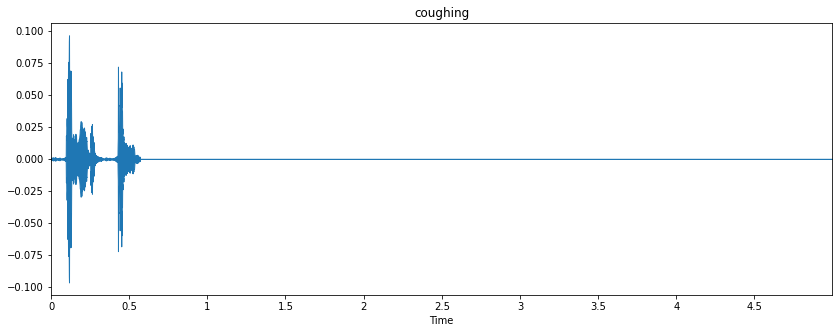

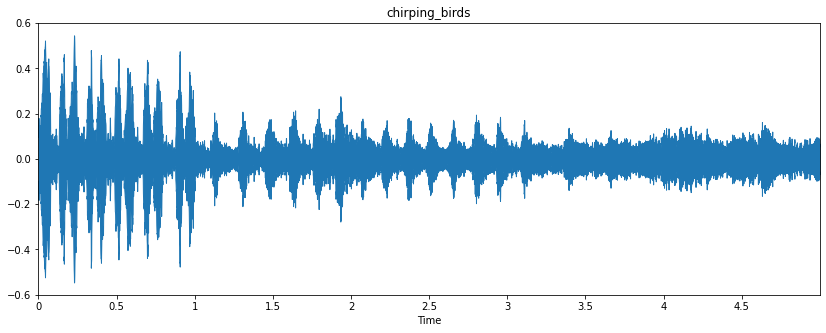

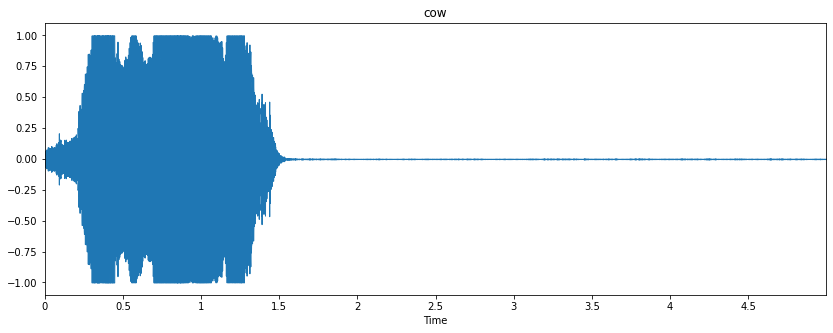

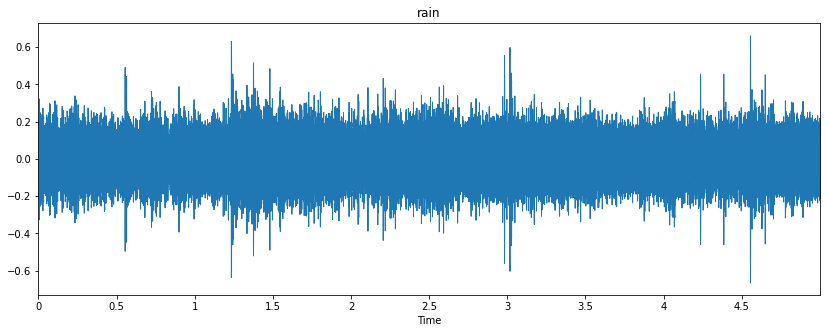

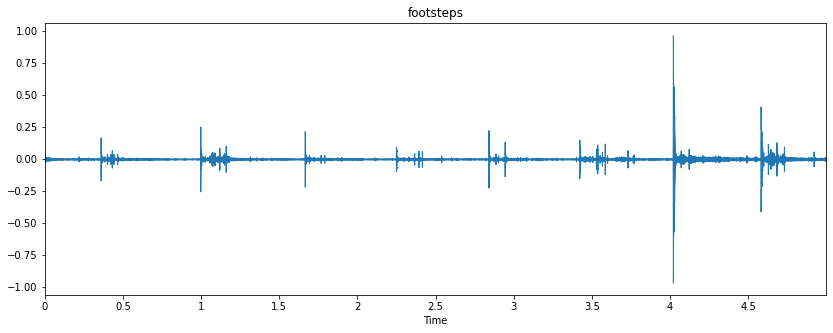

In [ ]:
for key, value in sample.items():
  waveform(value, key)

2.Spectograms

In [ ]:
def spectogram(audio_path, audio_type):
  x,sr = librosa.load(audio_path, sr=None)
  X = librosa.stft(x)
  sgram_mag, _ = librosa.magphase(X)
  mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
  librosa.display.specshow(mel_scale_sgram)
  mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
  fig = plt.Figure(figsize=(5,5))
  plt.title(audio_type)
  librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
  #plt.colorbar(format='%+2.0f dB')
  fig.savefig('drive/MyDrive/not cough/'+str(999)+'.jpeg',bbox_inches='tight',pad_inches = 0)


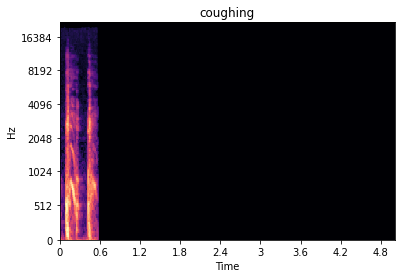

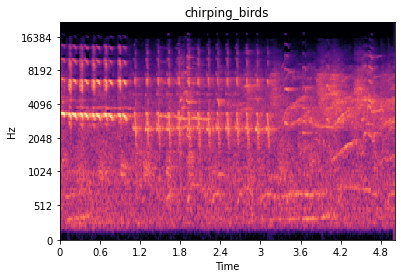

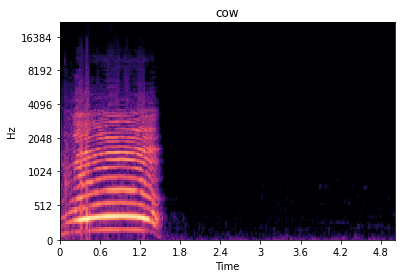

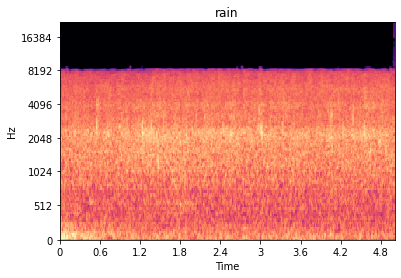

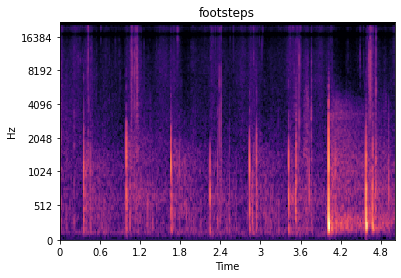

In [ ]:
 for key,value in sample.items():
    plt.figure(value)
    spectogram(value,key) 

# Model Prep

The feature column is an array of 40 elements. We have to split the array to crate a column for each element for analysis

In [10]:
X = pd.DataFrame(features_df.feature.tolist())


In [15]:
y = pd.DataFrame(features_df.label.tolist(),columns=['label'])


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [17]:
y_test.shape

(40, 1)

In [18]:
#Saving to use for resampling
train=pd.concat([X_train,y_train],axis=1)

In [19]:
X_train=X_train.values
X_val=X_val.values
X_test=X_test.values
y_train = np_utils.to_categorical(y_train)
y_val=np_utils.to_categorical(y_val)
y_test=y_test.values

# Model Building

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten,InputLayer
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint

In [21]:
def create_mlp(num_labels=2):
    model = Sequential()
    model.add(Dense(256,input_shape = (40,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,input_shape = (40,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(num_labels))
    model.add(Activation('sigmoid'))
    return model

In [22]:
def model_train(model,X_train, X_test, y_train, y_test,model_file):    
    # compile the model 
    model.compile(loss = 'binary_crossentropy',metrics=['accuracy'],optimizer='adam')
    print(model.summary())
    print("training for 100 epochs with batch size 32")
    history=model.fit(X_train,y_train,batch_size= 32, epochs = 100, validation_data=(X_test,y_test))
    # save model to disk
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print("Saving model to disk")
    model.save(model_file)

def compute(X_test,y_test,model_file):
    # load model from disk
    loaded_model = load_model(model_file)
    score = loaded_model.evaluate(X_test,y_test)
    return score[0],score[1]*100

Training..
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               10496     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 2)       

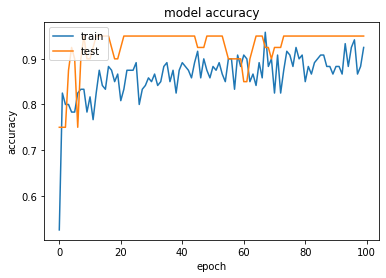

Saving model to disk
2/2 [==============================] - 0s 4ms/step - loss: 0.1987 - accuracy: 0.9500
Val loss 0.19868788123130798
Val accuracy 94.9999988079071


In [30]:
model= create_mlp()
print("Training..")
model_train(model,X_train, X_val, y_train, y_val,"trained_mlp.h5")

# compute val loss and accuracy
val_loss, val_accuracy = compute(X_val,y_val,"trained_mlp.h5")
print("Val loss",val_loss)
print("Val accuracy",val_accuracy)

The val accuracy is 95% which is quite good.

# Resampling
The dataset is small so let's try increasing the size by resampling and see if performance improves.

In [42]:
from sklearn.utils import resample
from sklearn.utils import shuffle

df_0=train[train['label']==0]
df_1=train[train['label']==1]

df_0_upsample=resample(df_0,replace=True,n_samples=500,random_state=122)
df_1_upsample=resample(df_1,replace=True,n_samples=500,random_state=123)

train_resampled=pd.concat([df_0_upsample,df_1_upsample])


In [43]:
y_train=train_resampled[['label']]
train_resampled = train_resampled.drop(['label'],axis=1)
X_train=train_resampled

In [44]:
X_train=X_train.values
y_train=np_utils.to_categorical(y_train,2)

Training..
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               10496     
                                                                 
 activation_12 (Activation)  (None, 256)               0         
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 activation_13 (Activation)  (None, 256)               0         
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 2)     

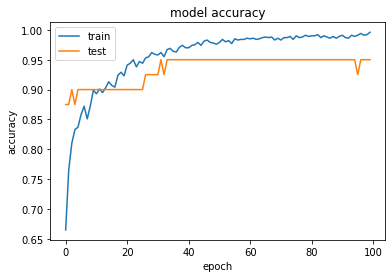

Saving model to disk
2/2 [==============================] - 0s 7ms/step - loss: 1.9791 - accuracy: 0.9500
val loss 1.979127287864685
Val accuracy 94.9999988079071


In [47]:
model= create_mlp()
print("Training..")
model_train(model,X_train, X_val, y_train, y_val,"trained_mlp.h5")

# compute val loss and accuracy
val_loss, val_accuracy = compute(X_val,y_val,"trained_mlp.h5")
print("val loss",val_loss)
print("Val accuracy",val_accuracy)

The training curve is now more consistent but the validation accuracy remains the same


              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.94      0.97      0.95        31

    accuracy                           0.93        40
   macro avg       0.91      0.87      0.89        40
weighted avg       0.92      0.93      0.92        40



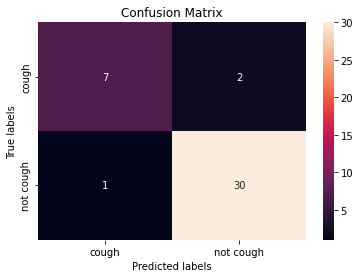

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

#not cough is 1, cough is 0
print(classification_report(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['cough', 'not cough']); ax.yaxis.set_ticklabels(['cough', 'not cough']);


f1 score on test data is 93%

#Teachable machine
To train the teachable machine, we will convert each audio file into a spectogram. There are totally 200 data points so we will take a train:test ratio of 75:25.





In [29]:
not_cough=filtered_pd[filtered_pd['target']==1]
cough=filtered_pd[filtered_pd['target']==0]
cough_files=cough['filename'].values
not_cough_files=not_cough['filename'].values

In [30]:
test_files=[]

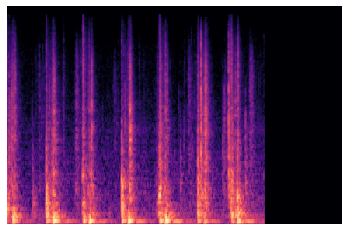

In [31]:
image_no = 1
for file_name in not_cough_files: 
  x,sr = librosa.load(file_name, sr=None)
  X = librosa.stft(x)
  sgram_mag, _ = librosa.magphase(X)
  mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
  librosa.display.specshow(mel_scale_sgram)
  mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
  fig = plt.Figure(figsize=(5,5))
  librosa.display.specshow(mel_sgram, sr=sr)
  # We need to create images without any axis lables so that it can be trained
  plt.axis('off')
  # Taking only first 40 images as test set images and rest for training
  if image_no>40:
    plt.savefig('drive/MyDrive/not_cough/'+str(image_no)+'.jpeg',bbox_inches='tight',pad_inches = 0) 
  elif image_no<=40:
    plt.savefig('drive/MyDrive/test/'+str(image_no+10)+'.jpeg',bbox_inches='tight',pad_inches = 0) 
    test_files.append(file_name)
  image_no+=1

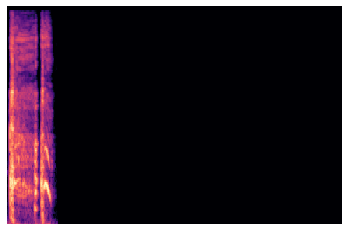

In [32]:
image_no = 1
for file_name in cough_files: 
  x,sr = librosa.load(file_name, sr=None)
  X = librosa.stft(x)
  sgram_mag, _ = librosa.magphase(X)
  mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
  librosa.display.specshow(mel_scale_sgram)
  mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
  fig = plt.Figure(figsize=(5,5))
  librosa.display.specshow(mel_sgram, sr=sr)
  plt.axis('off')
  # Taking only first 10 images as test set images and rest for training 
  if image_no>10:
    plt.savefig('drive/MyDrive/cough_/'+str(image_no)+'.jpeg',bbox_inches='tight',pad_inches = 0) 
  elif image_no<=10:
    plt.savefig('drive/MyDrive/test/'+str(image_no)+'.jpeg',bbox_inches='tight',pad_inches = 0)
    test_files.append(file_name) 
  image_no+=1

In [33]:
test_df= filtered_pd[filtered_pd["filename"].isin(test_files)]


In [34]:
test_df=test_df[['filename','target']]

In [35]:
# dataframe of all test file names and target values
test_df

,filename,target
1,./datasets/ESC-50-master/audio/1-100038-A-14.wav,1
39,./datasets/ESC-50-master/audio/1-155858-A-25.wav,1
40,./datasets/ESC-50-master/audio/1-155858-B-25.wav,1
41,./datasets/ESC-50-master/audio/1-155858-C-25.wav,1
42,./datasets/ESC-50-master/audio/1-155858-D-25.wav,1
43,./datasets/ESC-50-master/audio/1-155858-E-25.wav,1
44,./datasets/ESC-50-master/audio/1-155858-F-25.wav,1
49,./datasets/ESC-50-master/audio/1-16568-A-3.wav,1
62,./datasets/ESC-50-master/audio/1-17367-A-10.wav,1
84,./datasets/ESC-50-master/audio/1-19111-A-24.wav,0


Loading the exported model from teachable machine and testing its preformance on test data:

In [37]:
from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np

# Load the model
model = load_model('drive/MyDrive/keras_model.h5')

model.compile(loss = 'binary_crossentropy',metrics=['accuracy'],optimizer='adam')
# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1.
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
y_pred=[]
# Replace this with the path to your image
for i in range(1,51):
  image = Image.open('drive/MyDrive/test/'+str(i)+'.jpeg')
  #resize the image to a 224x224 with the same strategy as in TM2:
  #resizing the image to be at least 224x224 and then cropping from the center
  size = (224, 224)
  image = ImageOps.fit(image, size, Image.ANTIALIAS)

  #turn the image into a numpy array
  image_array = np.asarray(image)
  # Normalize the image
  normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
  # Load the image into the array
  data[0] = normalized_image_array

  # run the inference
  prediction = model.predict(data)
  predicted_class=np.argmax(prediction[0],axis=0)
  y_pred.append(predicted_class)


              precision    recall  f1-score   support

           0       0.09      0.10      0.10        10
           1       0.77      0.75      0.76        40

    accuracy                           0.62        50
   macro avg       0.43      0.42      0.43        50
weighted avg       0.63      0.62      0.63        50



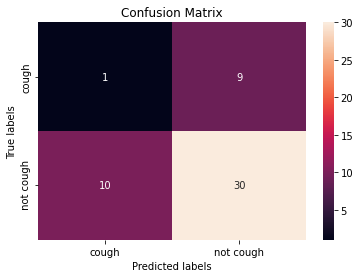

In [40]:
# not cough is 1, cough is 0
print(classification_report(test_df['target'].values,y_pred))
cm=confusion_matrix(test_df['target'].values,y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['cough', 'not cough']); ax.yaxis.set_ticklabels(['cough', ' not cough']);


The model has done a poor job in classifying the sounds. It does a better job in classifying non cough sounds rather than cough sounds. This may be due to the fact the test data is small and data available for non cough sounds are more than cough sounds

Further work may be done by generating more images to create a larger training set.
